<a href="https://colab.research.google.com/github/ssamadjon3106/PyTorch-with-Deep-Learning/blob/main/06_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [66]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [67]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [68]:
import os
import zipfile
from pathlib import Path
import requests

data_path=Path('data/')
image_path=data_path/'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} exists')
else:
  print(f'{image_path} downloading...')
  image_path.mkdir(parents=True,exist_ok=True)

  with open(data_path/'pizza_steak_sushi.zip', 'wb') as f:
    request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(request.content)

  with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip','r') as zip_ref:
    zip_ref.extractall(image_path)
  os.remove(data_path/'pizza_steak_sushi.zip')



data/pizza_steak_sushi exists


In [69]:
train_dir=image_path/'train'
test_dir=image_path/'test'

In [70]:
from torchvision import transforms
normalize=transforms.Normalize(mean=[0.485, .0456, 0.0406],
                               std=[0.229, 0.224, 0.225])
manual_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [71]:
from torchvision import transforms, datasets
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir, test_dir, manual_transforms, batch_size=32)

In [72]:
train_dataloader

In [73]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [74]:
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [75]:
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(train_dir, test_dir, transform=auto_transform, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e50b8c3e9c0>,
 ['pizza', 'steak', 'sushi'])

In [76]:
# getting pretrained-model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [77]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [78]:
summary(model, input_size=(1, 3, 224, 224), col_names=['input_size'], col_width=20)

Layer (type:depth-idx)                                  Input Shape
EfficientNet                                            [1, 3, 224, 224]
├─Sequential: 1-1                                       [1, 3, 224, 224]
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]
│    └─Sequential: 2-2                                  [1, 32, 112, 112]
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]
│    └─Sequential: 2-3                                  [1, 16, 112, 112]
│    │    └─MBConv: 3-5                                 [1, 16, 112, 112]
│    │    └─MBConv: 3-6                                 [1, 24, 56, 56]
│    └─Sequential: 2-4                                  [1, 24, 56, 56]
│    │    └─MBConv: 3-7                             

In [79]:
#Freezing base model and changing output_shape
for param in model.features.parameters():
  param.requires_grad=False

In [80]:
# updata classifier
from torch import nn
torch.manual_seed(42)
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)
model.classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [81]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [82]:
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)


In [83]:
from going_modular.going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_timer=timer()
results=engine.train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,optimizer=optimizer, loss_fn=loss_fn, epochs=5, device=device)
end_timer=timer()
print(f'INFO time:{end_timer-start_timer} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
INFO time:15.74965333299997 seconds


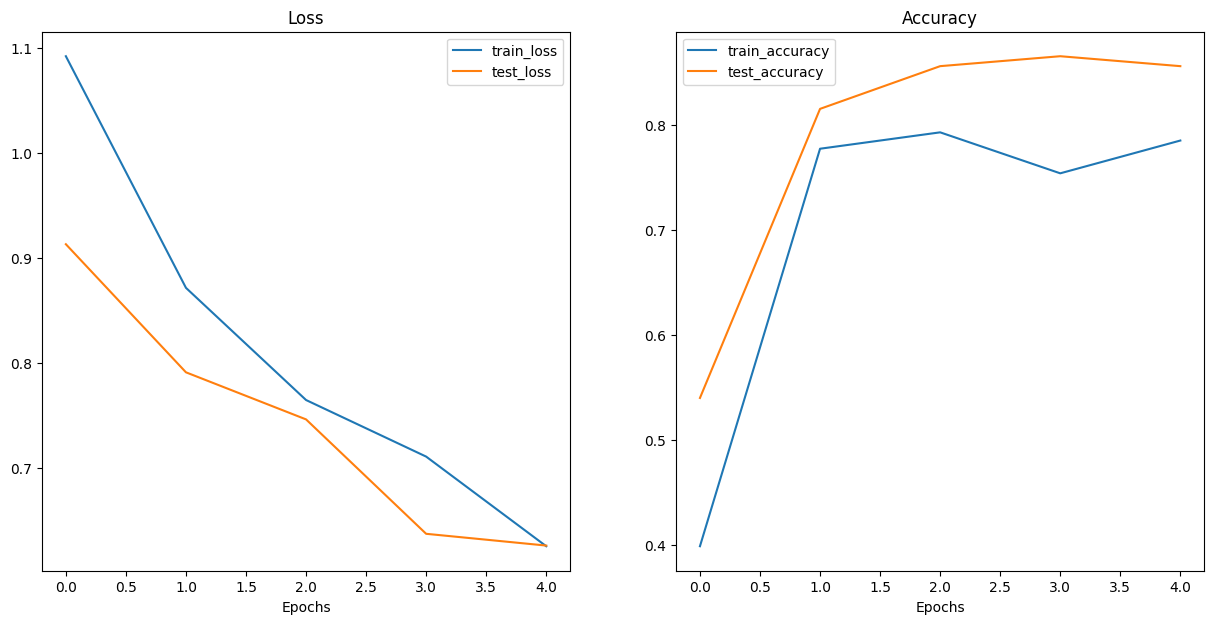

In [84]:
import requests

with open('helper_functions.py', 'wb') as f:
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  f.write(request.content)

from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [85]:
from typing import List, Tuple
import PIL
def pred_and_plot_image(model: nn.Module, class_names: List[str], filepath:str, image_size: Tuple[int, int]=(224, 224), transform: torchvision.transforms=None, device:torch.device=device):
  img=PIL.Image.open(filepath)
  if transform:
    image_transform=transform
  else:
    image_transform=weights.transforms()

  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0)
    target_image_pred=model(transformed_image.to(device))

  target_image_pred_probs=torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_pred_probs, dim=1)
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs}")

In [86]:
import random
n=3
test_image_path_list=list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample=random.sample(population=test_image_path_list, k=n)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/988559.jpg')]

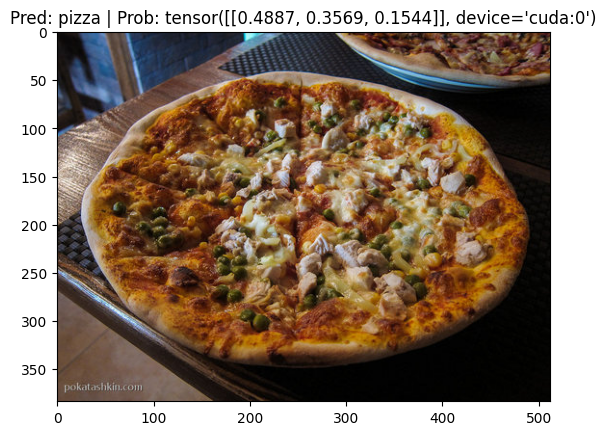

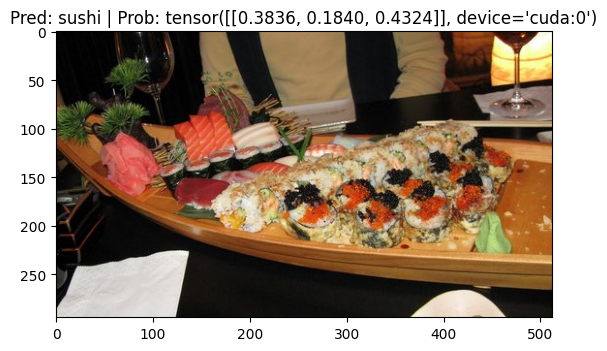

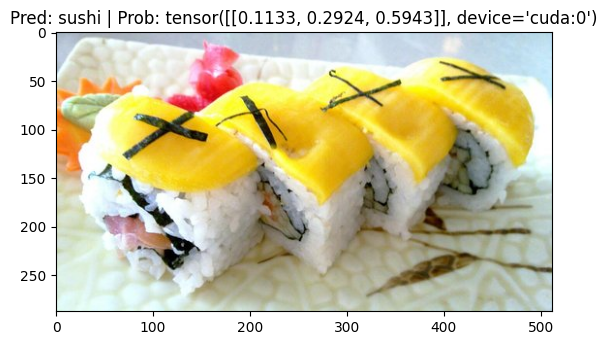

In [87]:
for i in test_image_path_sample:
  pred_and_plot_image(model=model, class_names=class_names, filepath=i, image_size=(224,224))

Removed existing data/pizza-image2.jpg to force re-download.


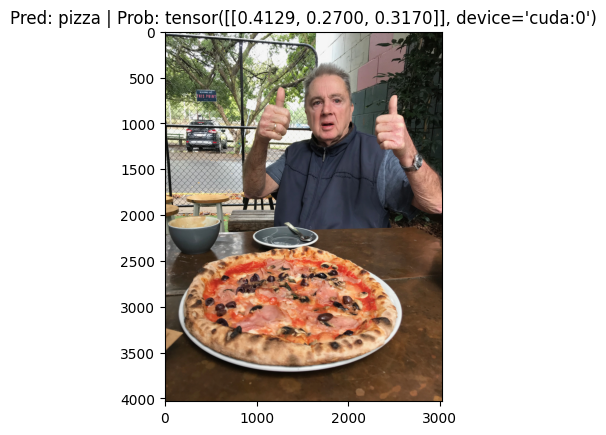

In [88]:
# Download custom image
import requests
import os

# Setup custom image path
custom_image_path = data_path / "pizza-image2.jpg"

# Force re-download by removing the file if it exists
if custom_image_path.is_file():
    os.remove(custom_image_path)
    print(f"Removed existing {custom_image_path} to force re-download.")

# Download the image
request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/04-pizza-dad.jpeg")
# Check if the request was successful
if request.status_code == 200:
    with open(custom_image_path, "wb") as f:
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
    # Predict on custom image only if download was successful
    pred_and_plot_image(model=model,
                        filepath=custom_image_path,
                        class_names=class_names)
else:
    print(f"Error: Failed to download image from URL. Status code: {request.status_code}")
    print("Please check the URL or your internet connection.")

In [89]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [90]:
len(test_dataloader)

3

In [91]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [92]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [93]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [94]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.12/dist-packages/numpy/_core/umath.py)

In [95]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

ImportError: cannot import name '_center' from 'numpy._core.umath' (/usr/local/lib/python3.12/dist-packages/numpy/_core/umath.py)

In [97]:
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]
      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5425673127174377,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.40159863233566284,
  'pred_class': 'steak',
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5216758251190186,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5978302955627441,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.39557597041130066,
  'pred_class': 'steak',
  'correct': False}]

In [98]:
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
44,data/pizza_steak_sushi/test/sushi/3837522.jpg,sushi,0.555925,steak,False
39,data/pizza_steak_sushi/test/steak/27415.jpg,steak,0.519717,sushi,False
57,data/pizza_steak_sushi/test/sushi/46797.jpg,sushi,0.519172,steak,False
62,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.496107,steak,False
16,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,0.495616,steak,False


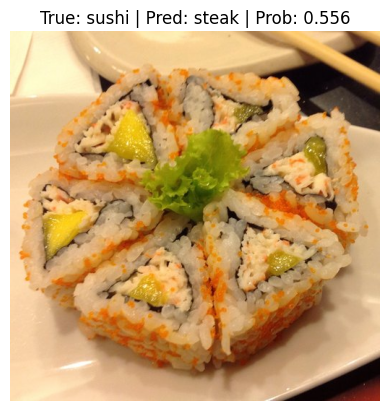

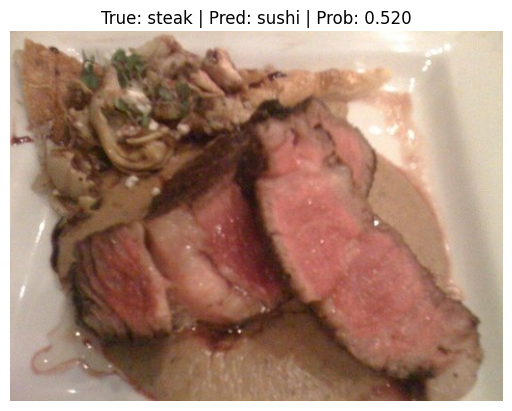

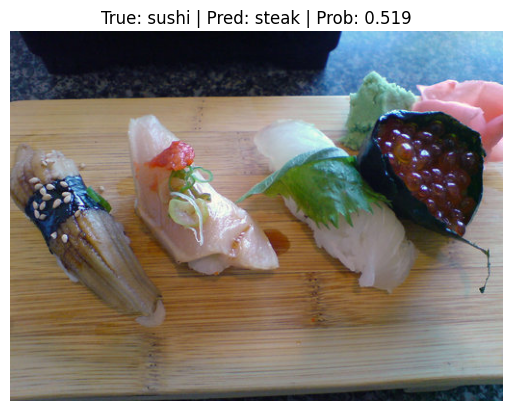

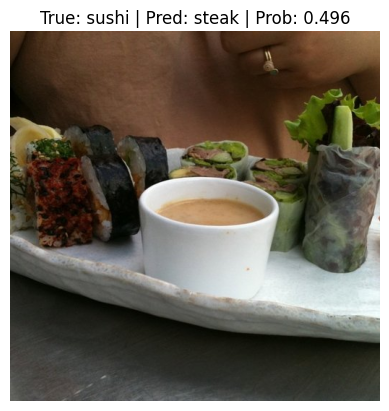

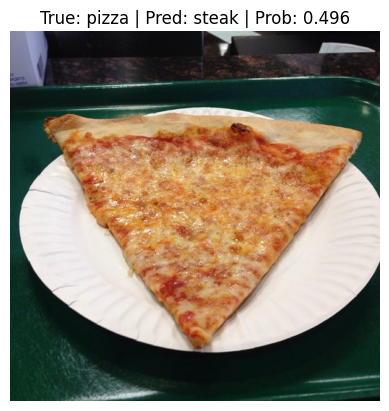

In [100]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row['image_path']
  true_label = row['class_name']
  pred_prob = row['pred_prob']
  pred_class = row['pred_class']
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);